In [ ]:
!pip3 uninstall torch torchvision --yes

In [ ]:
!pip3 install torch==1.11.0 torchvision==0.12

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

import time
import os
import copy
import random

import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0+cu102
Torchvision Version:  0.12.0+cu102


In [2]:
train = pd.read_csv(r'/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv(r'/kaggle/input/digit-recognizer/test.csv')

In [3]:
y_train = train['label']
X_train = train.drop('label', axis=1)

In [4]:
X_train /= 255.
test /= 255.

In [5]:
X_train.shape

(42000, 784)

In [6]:
y_train.shape

(42000,)

In [7]:
dataset_sizes = {'train': len(X_train), 'test':len(test)}

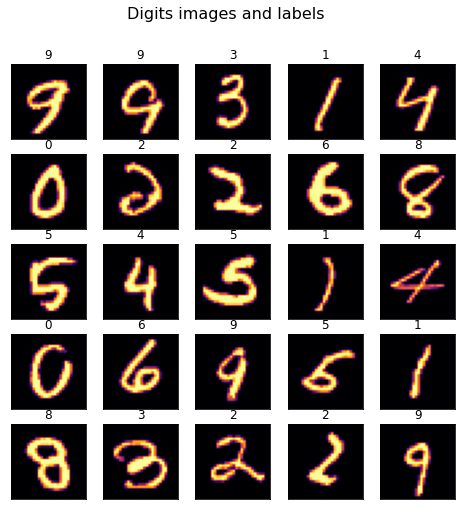

In [8]:
fig, ax = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Digits images and labels', fontsize=16)
ax = ax.ravel()
for i in range(25):
    sample_n = random.randint(0, X_train.shape[0])
    ax[i].imshow(np.array(X_train.iloc[sample_n]).reshape(28, 28), cmap='inferno')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(y_train[sample_n], fontsize = 12)

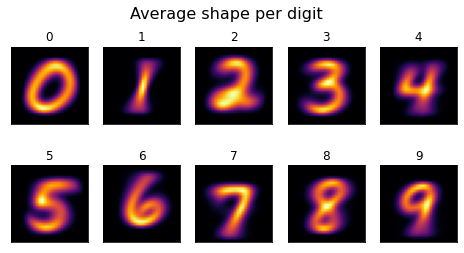

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle('Average shape per digit', fontsize=16)

ax = ax.ravel()

for i in range(10):
    ax[i].imshow(np.array(train[train['label'] == i].drop('label', axis=1).mean()).reshape(28, 28), cmap='inferno')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(i, fontsize = 12)

In [10]:
X_train_array = np.array(X_train)
X_train_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
test_array = np.array(test)
test_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
X_train_array = X_train_array.reshape(42000, 1, 28, 28)
test_array = test_array.reshape(-1, 1, 28, 28)

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

In [14]:
train_data = []
for i in range(len(X_train_array)):
   train_data.append([X_train_array[i], y_train[i]])
dataloaders = {'train': torch.utils.data.DataLoader(train_data, batch_size=32,
                                             shuffle=True, num_workers=4)
              ,'test':  torch.utils.data.DataLoader(test_array, batch_size=20,
                                             shuffle=False, num_workers=4)}

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
# training_loader = dataloaders['train']
# dataiter = iter(training_loader)
# images, labels = dataiter.next()
# images = images.float()

In [41]:
# model_ft = models.VisionTransformer(image_size=28, patch_size=2,  num_layers=12, num_heads=12, 
#                                     hidden_dim=768, mlp_dim=3072, dropout = 0.1, emb_dropout = 0.1)
model_ft = models.VisionTransformer(image_size=28, patch_size=4,  num_layers=12, num_heads=12, 
                                    hidden_dim=768, mlp_dim=3072)# dropout = 0.1, emb_dropout = 0.1)

num_ftrs = model_ft.heads.head.in_features
model_ft.heads.head = nn.Linear(num_ftrs, 10)

model_ft.conv_proj = torch.nn.Conv2d(1, 768, kernel_size=(4, 4), stride=(4, 4))
# model_ft.conv_proj = torch.nn.Conv2d(1, 768, kernel_size=(2, 2), stride=(2, 2))

In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    model.to(device)
    since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_num, [inputs, labels] in enumerate(tqdm.tqdm(dataloaders[phase])):
                inputs = inputs.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    torch.save(model.state_dict(), 'model.pt')

    return model

In [44]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0003)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ft, T_0=5, T_mult=1, eta_min=0, last_epoch=-1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


100%|██████████| 1313/1313 [03:30<00:00,  6.24it/s]


train Loss: 1.2021 Acc: 0.5598

Epoch 1/14
----------


100%|██████████| 1313/1313 [03:30<00:00,  6.24it/s]


train Loss: 0.4919 Acc: 0.8408

Epoch 2/14
----------


 70%|███████   | 923/1313 [02:28<01:02,  6.25it/s]

In [ ]:
def prediction(model, data_loader):
    model.to(device)
    model.eval()
    test_pred = torch.LongTensor()
    with torch.no_grad():        
        for i, data in enumerate(tqdm.tqdm(data_loader)):
            data = data.float()
            data = data.to(device)

            output = model(data)

            _,pred = torch.max(output,1) 
            test_pred = torch.cat((test_pred,pred.cpu()),dim=0)
          
        
    return test_pred

In [ ]:
test_loader = dataloaders['test']
test_pred = prediction(model_ft, test_loader)
predictions = test_pred.numpy()

In [ ]:
submission = pd.read_csv(r'/kaggle/input/digit-recognizer/sample_submission.csv')

In [ ]:
submission['Label'] = predictions

In [ ]:
submission.to_csv('/kaggle/working/t_submission.csv',index = False)

In [ ]:
test.shape